<a href="https://colab.research.google.com/github/nagae/ICL_B_2021/blob/main/japan_case_death_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 国内編：感染死亡率(7日ラグ)を求めてプロットする
以下，[平均感染期間が5日程度](https://www.niid.go.jp/niid/ja/typhi-m/iasr-reference/2536-related-articles/related-articles-492/10177-492r02.html)という情報があったので感染から死亡までのラグを**1週間**としてみます．つまり，
```
t日目の感染死亡率 = t日目の累積死亡数 ÷ (t-7)日目の累積感染数
```
とします．ただし，$t<7$の場合は感染死亡率は未定義(`NaN`)とします．

各県の感染死亡率を出すには `groupby` と `shift` を使います． (t-7)日目の各県の累積感染数とt日目の各県の累積死亡数は，それぞれ，
```
case7 = jp_df.groupby("都道府県")["陽性数"].shift(7) # 7日ラグの感染者数
death = jp_df.groupby("都道府県")["死亡数"].shift(0) # ラグなしの死亡数
```
で求められるので，その比を"感染死亡率"という列として `jp_df` に与えておくと便利そうです:
```
jp_df["感染死亡率"] = death/case7 # jp_df に7日ラグの感染死亡数を追加
```

日本全国の感染死亡率は，上述の case7 と death を各日について集計したものの比なので，以下のようにして求められます：
```
total_case7 = case7.groupby("年月日").sum() # 日本全国の日別の感染者(7日ラグ)
total_death = death.groupby("年月日").sum() # 日本全国の日別の死亡数
total_case_death_rate = total_death/total_case7 # 日本全国での感染死亡率
```

In [1]:
# 必要なモジュールのインポート
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, dates as mdates
import datetime
# ファイルを読み込み，列名を使いやすい形に修正
fname = 'https://toyokeizai.net/sp/visual/tko/covid19/csv/prefectures.csv'
jp_df = pd.read_csv(fname, dtype=str)
jp_df.columns = [ "年", "月", "日", "都道府県", "Pref", "陽性数", "検査数", "入院数", "重症数","退院数", "死亡数","実効再生産数"]
# 都道府県名以外の全てのセルを整数値に変換する
for c in jp_df.columns:
    if c in ["都道府県", "Pref"]: # 都道府県名のデータは文字型として扱う
        jp_df[c] = jp_df[c].astype(str)
    else:
        jp_df[c] = pd.to_numeric(jp_df[c], errors='coerce') # 都道府県名以外のデータは数値として扱う
        jp_df[c] = jp_df[c].fillna(0) # データが欠損している部分を0で埋める
        jp_df[c] = jp_df[c].astype(float) # 一旦は実数型に変換する 
        if c not in ["実効再生産数"]: # 実効再生産数以外のデータは整数型として扱う
            jp_df[c] = jp_df[c].astype(int)
# 年月日の列からdatetime型のインデックスを生成する
jp_df["年月日"] = pd.to_datetime(jp_df[["年", "月", "日"]].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d')
# 都道府県名と年月日からなるマルチインデックスを構築
jp_df = jp_df.set_index(["都道府県", "年月日"])
jp_df # jp_df の概観を表示

,,年,月,日,Pref,陽性数,検査数,入院数,重症数,退院数,死亡数,実効再生産数
都道府県,年月日,,,,,,,,,,,
東京都,2020-02-08,2020,2,8,Tokyo,3,0,0,0,0,0,0.00
神奈川県,2020-02-08,2020,2,8,Kanagawa,1,0,0,0,0,0,0.00
東京都,2020-02-09,2020,2,9,Tokyo,3,0,0,0,0,0,0.00
神奈川県,2020-02-09,2020,2,9,Kanagawa,1,0,0,0,0,0,0.00
東京都,2020-02-10,2020,2,10,Tokyo,3,0,0,0,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
熊本県,2021-05-22,2021,5,22,Kumamoto,5834,75676,907,27,4837,90,1.02
大分県,2021-05-22,2021,5,22,Oita,3137,138460,611,5,2489,37,0.69
宮崎県,2021-05-22,2021,5,22,Miyazaki,2939,38919,306,7,2594,25,0.68


In [18]:
case7 = jp_df.groupby("都道府県")["陽性数"].shift(7) # 7日ラグの感染者数
death = jp_df.groupby("都道府県")["死亡数"].shift(0) # ラグなしの死亡数
jp_df["感染死亡率"] = death/case7 # jp_df に7日ラグの感染死亡数を追加
# 日本全国の感染死亡率を求めておく
total_case7 = case7.groupby("年月日").sum() # 日本全国の日別の感染者(7日ラグ)
total_death = death.groupby("年月日").sum() # 日本全国の日別の死亡数
total_case_death_rate = total_death/total_case7 # 日本全国での感染死亡率

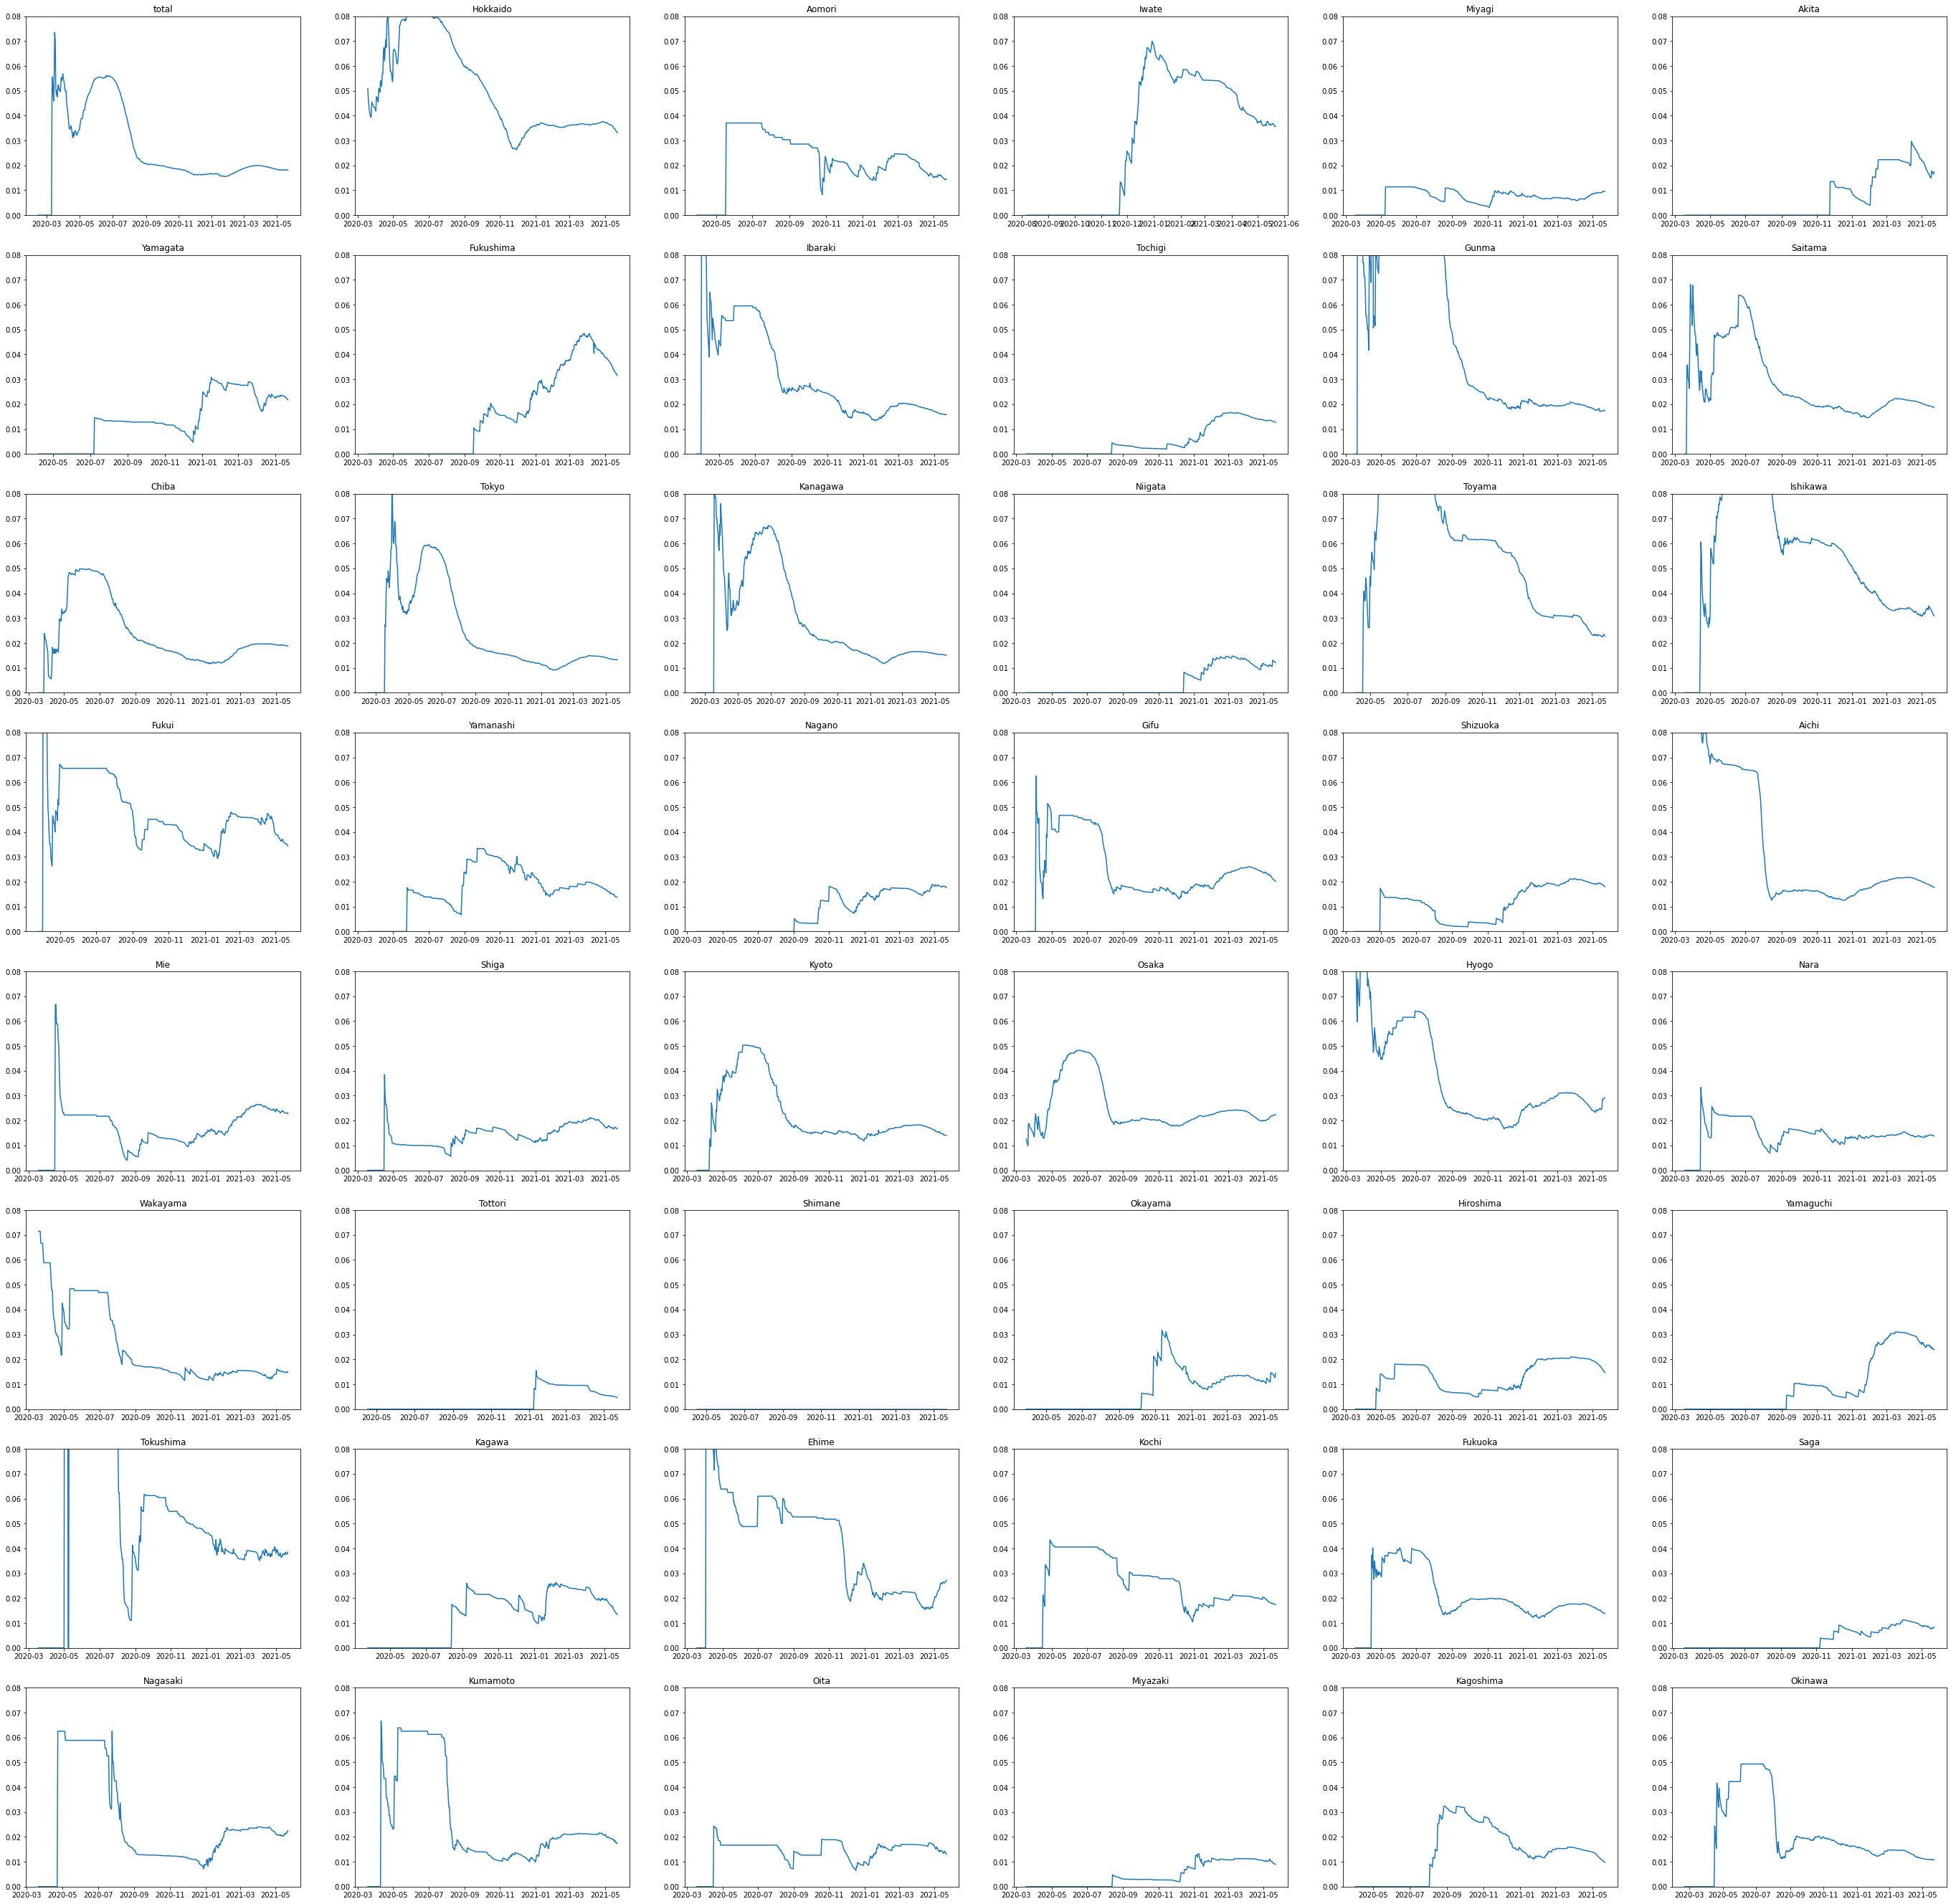

In [34]:
pref_set = ["全国"] + jp_df.tail(47).index.get_level_values(0).to_list() # 全県リスト
#pref_set = ["全国", "東京都", "宮城県"]
cols = 6 # タイルの列数
rows = np.ceil( len(pref_set) / cols ).astype(int) # タイルの行数
fig, ax = plt.subplots(rows, cols, figsize=(8*cols, 6*rows))
for pid, pref in enumerate(pref_set):
    r, c = pid // cols, pid % cols
    if pref == "全国":
        ax[r][c].plot(total_case_death_rate)
        ax[r][c].set_title("total")
    else:
        ax[r][c].plot(jp_df.loc[pref]["感染死亡率"])
        ax[r][c].set_title(jp_df.loc[pref]["Pref"][0])
    ax[r][c].set_ylim((0,0.08))